[saving](https://www.tensorflow.org/tutorials/keras/save_and_load)

In [1]:
import os
from tqdm.notebook import tqdm
import random
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable TF Warnings
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["tf_gpu_allocator"]="cuda_malloc_async"
warnings.filterwarnings("ignore")

checkpoint_folder_path = "training_checkpoints/"

# example filepath large_weights.{epoch:02d}-{val_loss:.2f}.hdf5

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!nvidia-smi

Mon Oct 30 01:33:24 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070        On  | 00000000:01:00.0  On |                  N/A |
|  0%   34C    P8               8W / 200W |   6600MiB / 12282MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import cv2

In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, ReLU, LeakyReLU, BatchNormalization, Add, Input, concatenate
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D

from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.utils.class_weight import compute_class_weight

In [6]:
sns.set(style='darkgrid', palette='deep')

tf.random.set_seed(42)

# Exploratory Data Analysis

The dataset consists of labelled images of vegetables including:
* Bean
* Bitter_Gourd
* Bottle_Gourd
* Brinjal
* Broccoli
* Cabbage
* Capsicum
* Carrot
* Cauliflower
* Cucumber
* Papaya
* Potato
* Pumpkin
* Radish
* Tomato

Provided are a train set (inconsistent number of samples for each class), a train set (200 samples/class), and a validation set (200 samples/class).

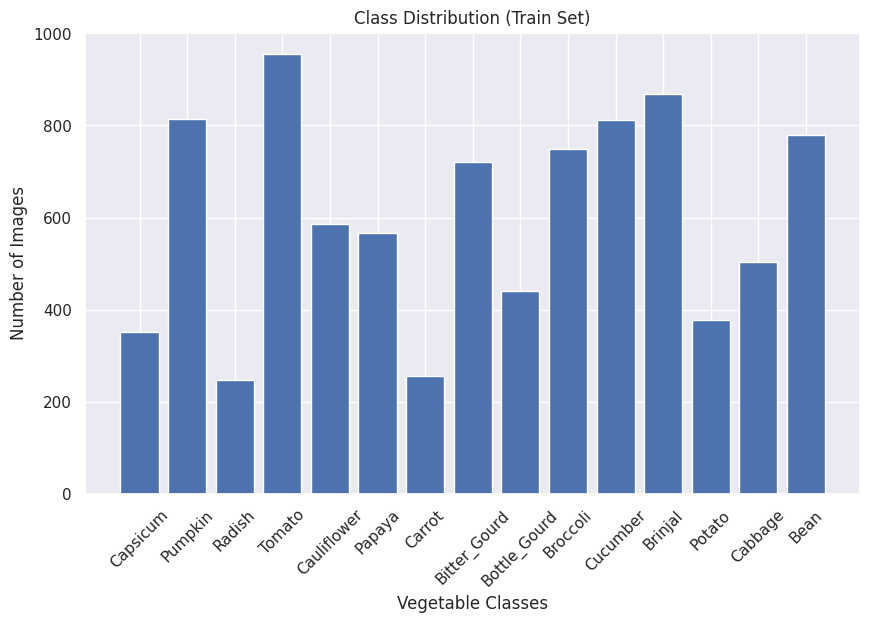

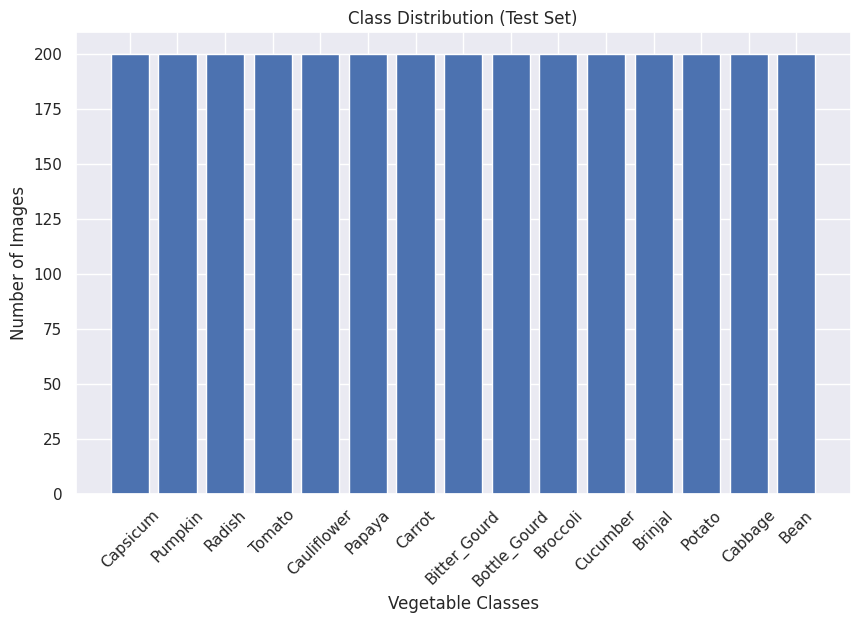

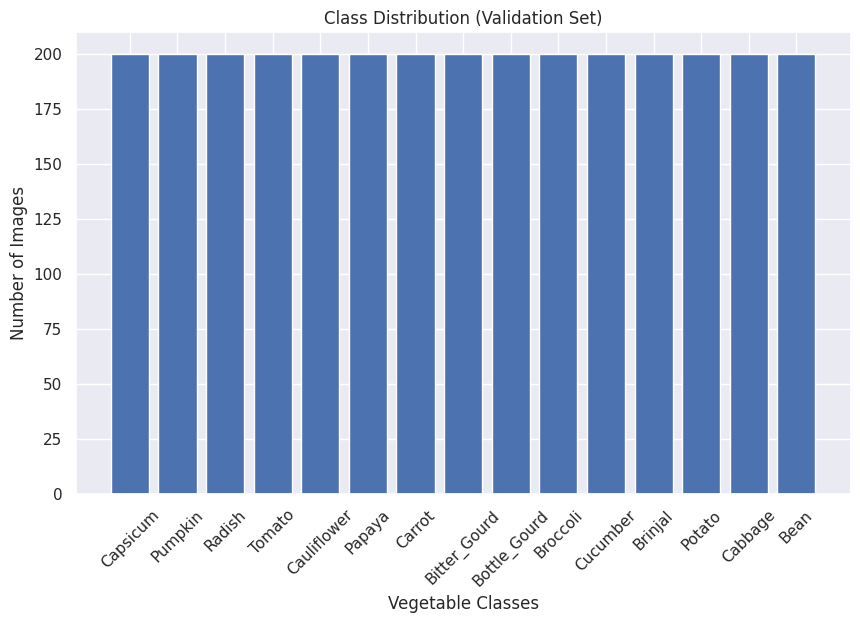

In [7]:
def plot_class_count_dir(dir, train):
    # Count the number of images in each class
    class_counts = {}
    for subdir, _, files in os.walk(dir):
        if subdir.split("/")[-1] != "":
            class_counts[subdir.split("/")[-1]] = len(files)
    
    # Plot class distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Vegetable Classes')
    plt.ylabel('Number of Images')
    plt.title(train)
    plt.xticks(rotation=45)
    plt.show()

plot_class_count_dir('Vegetable Images/train/', 'Class Distribution (Train Set)')
plot_class_count_dir('Vegetable Images/test/', 'Class Distribution (Test Set)')
plot_class_count_dir('Vegetable Images/validation/', 'Class Distribution (Validation Set)')

* Imbalanced Dataset
* Will have to via adjusting class weights, penalising the model more for incorrect classification of lower frequency class

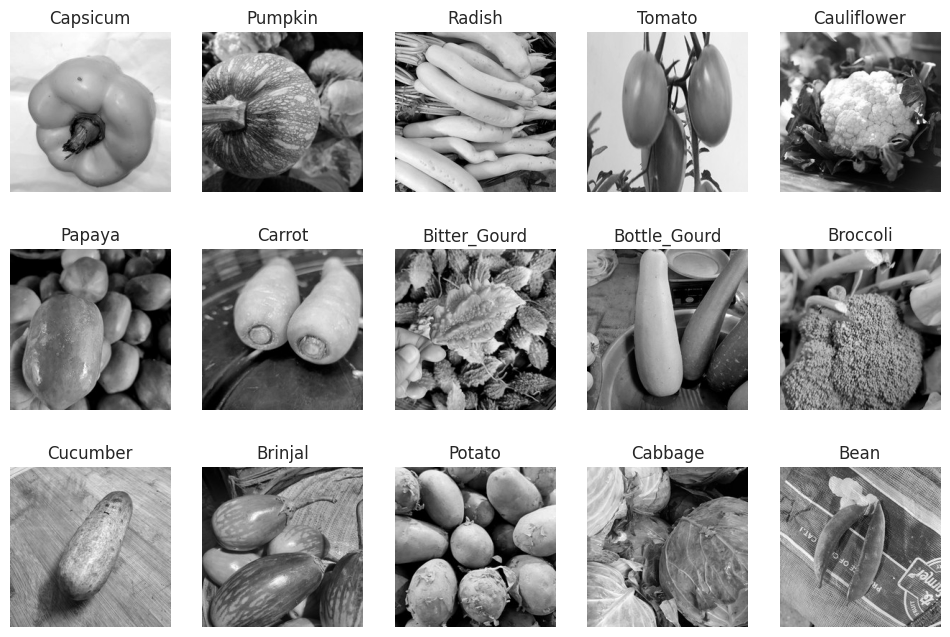

In [8]:
plt.figure(figsize=(12, 8))
for i in range(15):
    subdir = os.listdir('Vegetable Images/train/')[i]
    img_file = random.choice(os.listdir(os.path.join('Vegetable Images/train/', subdir)))
    img_path = os.path.join('Vegetable Images/train', subdir, img_file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(3, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(subdir)
    plt.axis('off')
plt.show()

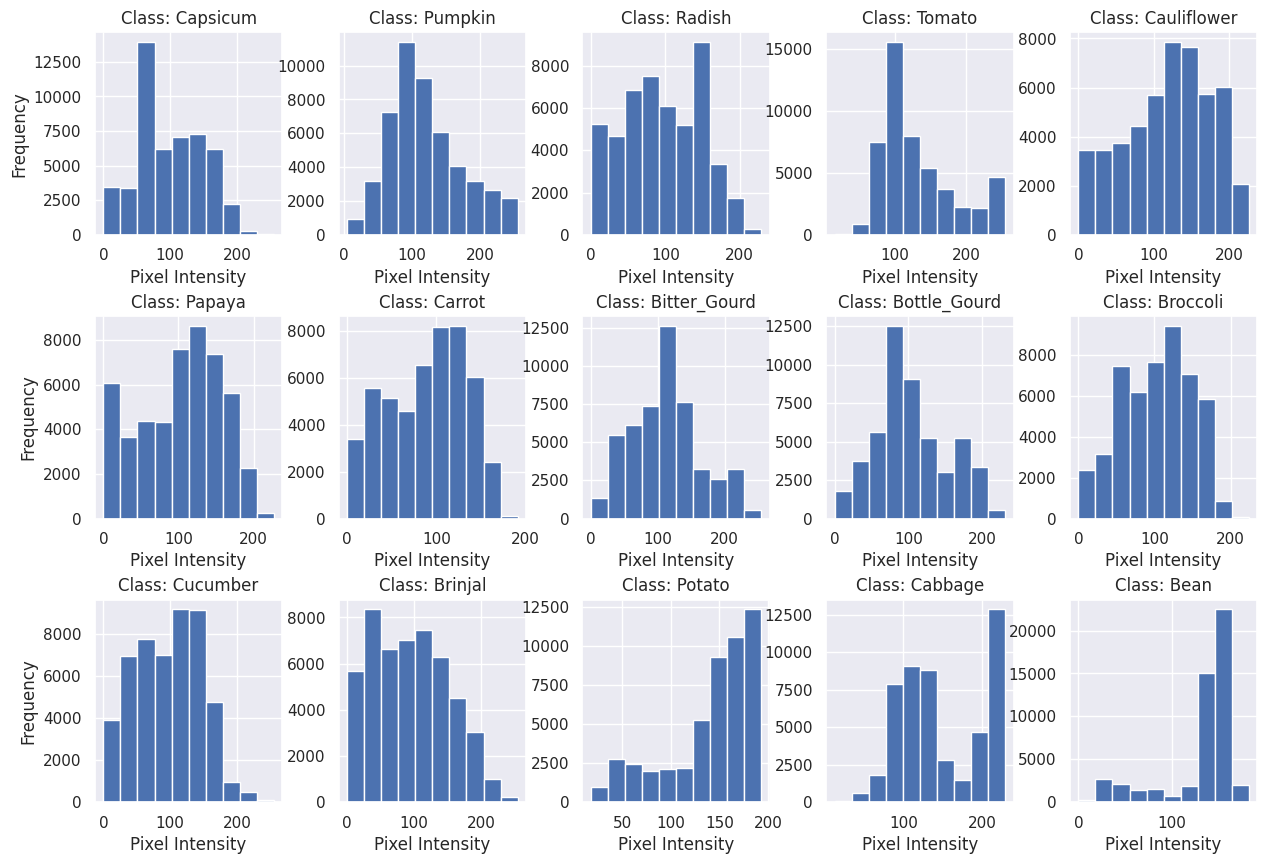

In [9]:
def plot_intensity_histogram(image_path, class_name, ax):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    ax.hist(img.ravel())
    ax.set_xlabel('Pixel Intensity')
    ax.set_title(f'Class: {class_name}')
    return ax

fig, axes = plt.subplots(3, 5, figsize=(15, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

class_folders = os.listdir('Vegetable Images/train/')
for i, class_folder in enumerate(class_folders):
    sample_image_path = os.path.join('Vegetable Images/train/', class_folder, os.listdir(f'Vegetable Images/train/{class_folder}')[0])
    row = i // 5
    col = i % 5
    ax = plot_intensity_histogram(sample_image_path, class_folder, axes[row, col])
    if col == 0:
        ax.set_ylabel('Frequency')

plt.show()

In [10]:
class_keys = {
    "Bean": 0,
    "Bitter_Gourd": 1,
    "Bottle_Gourd": 2,
    "Brinjal": 3,
    "Broccoli": 4,
    "Cabbage": 5,
    "Capsicum": 6,
    "Carrot": 7,
    "Cauliflower": 8,
    "Cucumber": 9,
    "Papaya": 10,
    "Potato": 11,
    "Pumpkin": 12,
    "Radish": 13,
    "Tomato": 14
}

inverted_class_keys = {v: k for k, v in class_keys.items()}

In [11]:
def load_images(folder_path, image_size):
    images = []
    labels = []
    counter = 0
    for subdir, _, files in os.walk(folder_path):
        for file in tqdm(files, desc=subdir):
            img_path = os.path.join(subdir, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img.shape != (image_size, image_size):
                img = cv2.resize(img, (image_size, image_size))
            images.append(img)
            labels.append(class_keys[subdir.split("/")[-1]])
            counter += 1
    
    images = np.array(images).reshape(-1, image_size, image_size, 1)
    return images, to_categorical(np.array(labels), 15)

# def resize_images(image_arr, image_size):
#     image_arr = [cv2.resize(img, (image_size, image_size)) for img in image_arr]
#     return np.array(image_arr).reshape(-1, image_size, image_size, 1)

train_images, train_labels = load_images('Vegetable Images/train/', 224)
test_images, test_labels = load_images('Vegetable Images/test/', 224)
val_images, val_labels = load_images('Vegetable Images/validation/', 224)

# small_train_images = resize_images(train_images, 31)
# small_test_images = resize_images(test_images, 31)
# small_val_images = resize_images(val_images, 31)


Vegetable Images/train/: 0it [00:00, ?it/s]

Vegetable Images/train/Capsicum:   0%|          | 0/351 [00:00<?, ?it/s]

Vegetable Images/train/Pumpkin:   0%|          | 0/814 [00:00<?, ?it/s]

Vegetable Images/train/Radish:   0%|          | 0/248 [00:00<?, ?it/s]

Vegetable Images/train/Tomato:   0%|          | 0/955 [00:00<?, ?it/s]

Vegetable Images/train/Cauliflower:   0%|          | 0/587 [00:00<?, ?it/s]

Vegetable Images/train/Papaya:   0%|          | 0/566 [00:00<?, ?it/s]

Vegetable Images/train/Carrot:   0%|          | 0/256 [00:00<?, ?it/s]

Vegetable Images/train/Bitter_Gourd:   0%|          | 0/720 [00:00<?, ?it/s]

Vegetable Images/train/Bottle_Gourd:   0%|          | 0/441 [00:00<?, ?it/s]

Vegetable Images/train/Broccoli:   0%|          | 0/750 [00:00<?, ?it/s]

Vegetable Images/train/Cucumber:   0%|          | 0/812 [00:00<?, ?it/s]

Vegetable Images/train/Brinjal:   0%|          | 0/868 [00:00<?, ?it/s]

Vegetable Images/train/Potato:   0%|          | 0/377 [00:00<?, ?it/s]

Vegetable Images/train/Cabbage:   0%|          | 0/503 [00:00<?, ?it/s]

Vegetable Images/train/Bean:   0%|          | 0/780 [00:00<?, ?it/s]

Vegetable Images/test/: 0it [00:00, ?it/s]

Vegetable Images/test/Capsicum:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Pumpkin:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Radish:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Tomato:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Cauliflower:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Papaya:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Carrot:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Bitter_Gourd:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Bottle_Gourd:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Broccoli:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Cucumber:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Brinjal:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Potato:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Cabbage:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Bean:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/: 0it [00:00, ?it/s]

Vegetable Images/validation/Capsicum:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Pumpkin:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Radish:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Tomato:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Cauliflower:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Papaya:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Carrot:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Bitter_Gourd:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Bottle_Gourd:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Broccoli:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Cucumber:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Brinjal:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Potato:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Cabbage:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Bean:   0%|          | 0/200 [00:00<?, ?it/s]

## Preprocessing: Data Augmentation 
#### Reasoning:
* Data augmentation effectively increases the size of the training dataset. With more diverse examples, the model can learn a broader range of patterns and become more robust. Especially with some classes only having about 200 training samples.
* Model will be more generalized and reduces overfitting from memorizing specific examples.

In [17]:
from keras.layers import RandomCrop, RandomContrast, RandomFlip, RandomRotation, RandomTranslation, RandomZoom, Resizing

# extremely slow in TF 2.10.0, can slow model as much as 6x

# image_augmentation = Sequential(
#     [
#         RandomFlip("horizontal_and_vertical"),
#         RandomContrast(0.5),
#         RandomRotation(1),
#         RandomZoom(0.5, 0.5)
#     ]
# )

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1/255
)

resize_small = Resizing(31, 31)
resize_large = Resizing(128, 128)

small_train_images = resize_small(train_images)
small_val_images = resize_small(val_images)
small_test_images = resize_small(test_images)

large_train_images = resize_large(train_images)
large_val_images = resize_large(val_images)
large_test_images = resize_large(test_images)

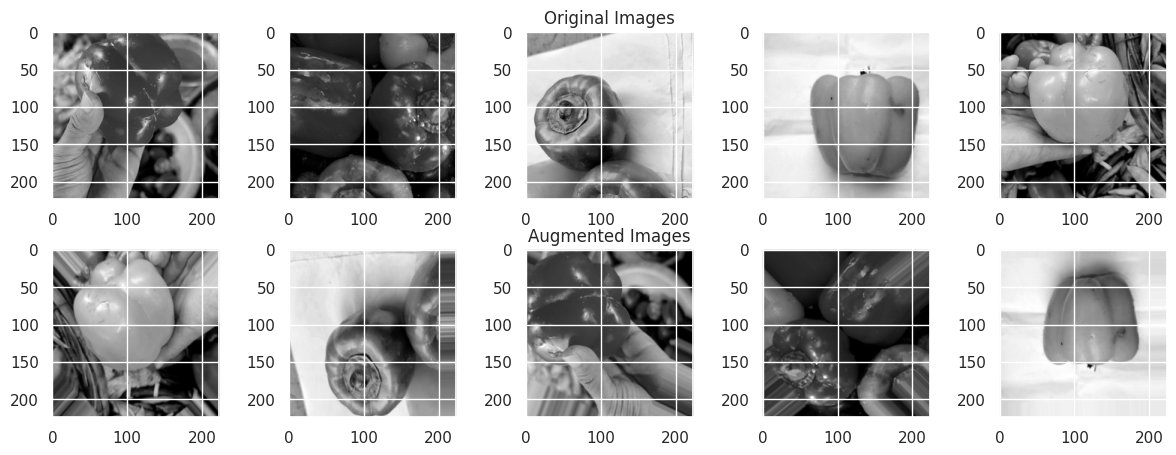

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

# axes = np.flatten(axes)
plt.subplots_adjust(hspace=0.3, wspace=0.1)

augmented = datagen.flow(train_images[:5])

for i in range(5):
    axes[0][i].imshow(train_images[i], cmap="gray")
    axes[1][i].imshow(augmented[0][i], cmap="gray")
    
    
axes[0][2].set_title("Original Images")
axes[1][2].set_title("Augmented Images")
    
plt.show()

This data augmentation is added as a preprocessing layer in the model and applied during model training.

### Calculating Class Weights

In [15]:
class_series = np.argmax(train_labels, axis=1)
class_labels = np.unique(class_series)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
class_weights = dict(zip(class_labels, class_weights))
print(class_weights)

{0: 0.7716239316239316, 1: 0.835925925925926, 2: 1.3647770219198792, 3: 0.693394777265745, 4: 0.8024888888888889, 5: 1.1965540092776674, 6: 1.7147198480531813, 7: 2.3510416666666667, 8: 1.0253265190232823, 9: 0.7412151067323481, 10: 1.0633686690223794, 11: 1.5964633068081344, 12: 0.7393939393939394, 13: 2.4268817204301074, 14: 0.6302268760907505}


Classes with the lowest sample count in the training set will have the greatest weight eg. 13: Radish

# Models for Large Images (128, 128)

## Basic CNN model à la VGG with 
* Image Augmentation Preprocessing

In [20]:
model_large = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(1000, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(15, activation='softmax')
])

# Compile the model
model_large.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

def fit_model(train, val, test, filepath):
    cp_callback = ModelCheckpoint(filepath=filepath, save_weights_only=True, save_best_only=True, verbose=1, save_freq='epo 
    
    history = model_large.fit(
        x = datagen.flow(large_train_images, train_labels, batch_size=50),
        epochs=50,
        batch_size=50,
        validation_data=(large_val_images, val_labels),
        callbacks=[cp_callback]
    )
    
    accuracy = model_large.evaluate(large_test_images, test_labels, verbose=0)[1]
    
    print(f"Accuracy for large images (128x128): {accuracy:.2f}")

checkpoint_folder_path = "training_checkpoints/"

# example filepath large_weights.{epoch:02d}-{val_loss:.2f}.hdf5

fit_model(large_train_images, large_val_images, large_test_images, "training_checkpoints/simple_large_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5")

Epoch 1/50
179/181 [============================>.] - ETA: 0s - loss: 2.5715 - accuracy: 0.1123
Epoch 1: val_loss improved from inf to 125.52675, saving model to training_checkpoints/simple_large_weights.01-0.09.hdf5
181/181 [==============================] - 7s 30ms/step - loss: 2.5698 - accuracy: 0.1128 - val_loss: 125.5267 - val_accuracy: 0.0857
Epoch 2/50
179/181 [============================>.] - ETA: 0s - loss: 2.2565 - accuracy: 0.2189
Epoch 2: val_loss did not improve from 125.52675
181/181 [==============================] - 5s 28ms/step - loss: 2.2566 - accuracy: 0.2187 - val_loss: 184.1416 - val_accuracy: 0.1500
Epoch 3/50
180/181 [============================>.] - ETA: 0s - loss: 2.0394 - accuracy: 0.2943
Epoch 3: val_loss did not improve from 125.52675
181/181 [==============================] - 5s 28ms/step - loss: 2.0403 - accuracy: 0.2940 - val_loss: 424.0049 - val_accuracy: 0.1057
Epoch 4/50
181/181 [==============================] - ETA: 0s - loss: 1.7584 - accuracy: 0.

KeyboardInterrupt: 

In [177]:
model_large.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_110 (Conv2D)         (None, None, None, 32)    320       
                                                                 
 conv2d_111 (Conv2D)         (None, None, None, 32)    9248      
                                                                 
 max_pooling2d_56 (MaxPooli  (None, None, None, 32)    0         
 ng2D)                                                           
                                                                 
 conv2d_112 (Conv2D)         (None, None, None, 64)    18496     
                                                                 
 conv2d_113 (Conv2D)         (None, None, None, 64)    36928     
                                                                 
 max_pooling2d_57 (MaxPooli  (None, None, None, 64)    0         
 ng2D)                                                

In [33]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()


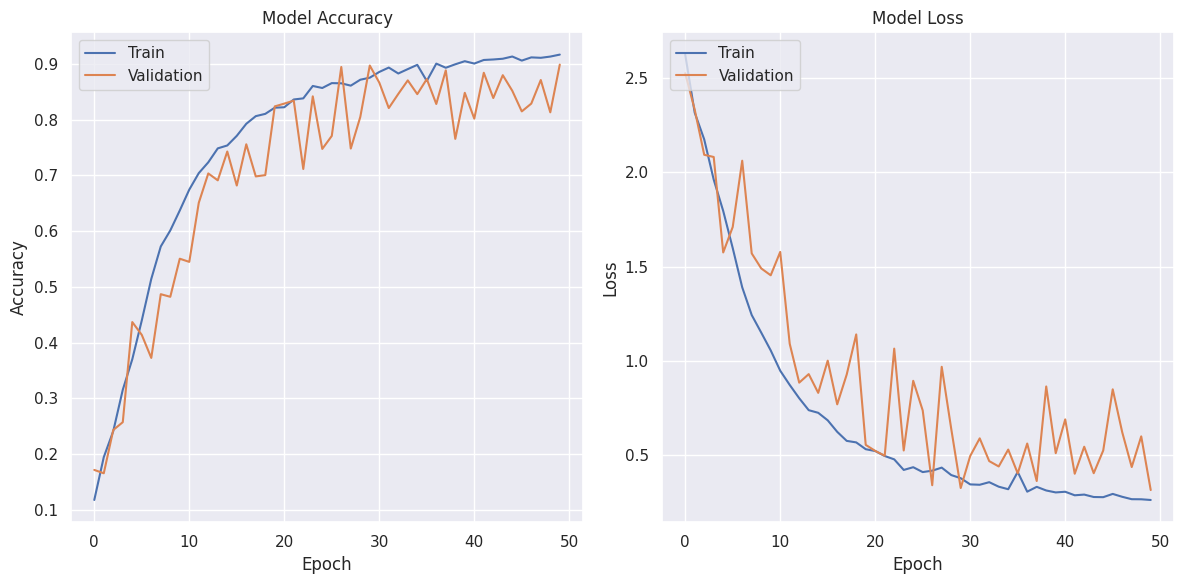

In [37]:
plot_history(history)

In [180]:
model_upscaled_small = tf.keras.models.clone_model(model_large, input_tensors=Input(shape=(128, 128, 1)))

model_upscaled_small.set_weights(model_large.get_weights())

# Compile the model
model_upscaled_small.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

ModelCheckpoint(filepath=checkpoint_paths["simple_large"], save_weights_only=True, verbose=1)

cp_callback = ModelCheckpoint(filepath=checkpoint_paths["simple_upscaled_small"], save_weights_only=True, verbose=1)

history = model_upscaled_small.fit(
    x = datagen.flow(resize_large(small_train_images), train_labels, batch_size=50),
    epochs=50,
    batch_size=50,
    validation_data=(resize_large(small_val_images), val_labels),
    callbacks=[cp_callback]
)

accuracy = model_upscaled_small.evaluate(resize_large(small_test_images), test_labels, verbose=0)[1]

print(f"Accuracy for small images (31x31): {accuracy:.2f}")

Epoch 1/50
179/181 [============================>.] - ETA: 0s - loss: 1.4936 - accuracy: 0.5172
Epoch 1: saving model to training_checkpoints/simple_upscaled_small.ckpt
181/181 [==============================] - 7s 31ms/step - loss: 1.4920 - accuracy: 0.5179 - val_loss: 1.0361 - val_accuracy: 0.6397
Epoch 2/50
181/181 [==============================] - ETA: 0s - loss: 1.1289 - accuracy: 0.6125
Epoch 2: saving model to training_checkpoints/simple_upscaled_small.ckpt
181/181 [==============================] - 6s 30ms/step - loss: 1.1289 - accuracy: 0.6125 - val_loss: 1.0203 - val_accuracy: 0.6523
Epoch 3/50
181/181 [==============================] - ETA: 0s - loss: 1.0207 - accuracy: 0.6589
Epoch 3: saving model to training_checkpoints/simple_upscaled_small.ckpt
181/181 [==============================] - 5s 30ms/step - loss: 1.0207 - accuracy: 0.6589 - val_loss: 0.8294 - val_accuracy: 0.7123
Epoch 4/50
180/181 [============================>.] - ETA: 0s - loss: 0.9749 - accuracy: 0.6675
E

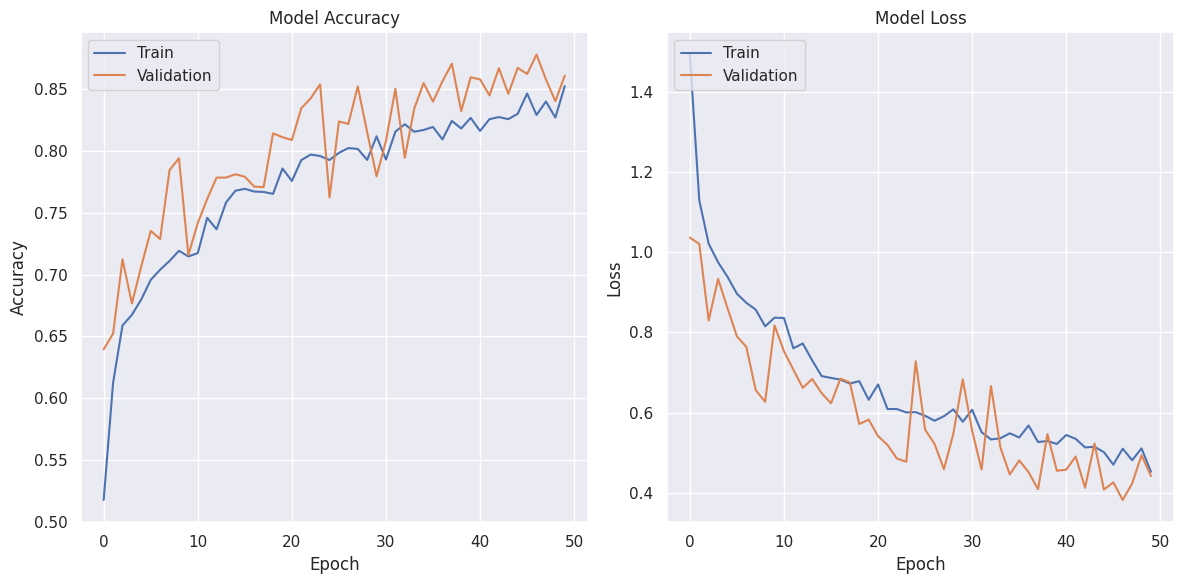

In [181]:
plot_history(history)

In [52]:
model_upscaled_small.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_110 (Conv2D)         (None, 126, 126, 32)      320       
                                                                 
 conv2d_111 (Conv2D)         (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_112 (Conv2D)         (None, 60, 60, 64)        18496     
                                                                 
 conv2d_113 (Conv2D)         (None, 58, 58, 64)        36928     
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 29, 29, 64)        0         
 ng2D)                                                

In [104]:
[x.shape for x in activations]

[TensorShape([1, 126, 126, 32]),
 TensorShape([1, 124, 124, 32]),
 TensorShape([1, 62, 62, 32]),
 TensorShape([1, 60, 60, 64]),
 TensorShape([1, 58, 58, 64]),
 TensorShape([1, 29, 29, 64]),
 TensorShape([1, 27, 27, 128]),
 TensorShape([1, 25, 25, 128]),
 TensorShape([1, 12, 12, 128]),
 TensorShape([1, 10, 10, 256]),
 TensorShape([1, 8, 8, 256]),
 TensorShape([1, 4, 4, 256]),
 TensorShape([1, 4, 4, 256]),
 TensorShape([1, 4096]),
 TensorShape([1, 1000]),
 TensorShape([1, 1000]),
 TensorShape([1, 15])]

In [169]:
layer_outputs = [layer.output for layer in model_upscaled_small.layers]  # Choose the layers you want to visualize
activation_model = Model(inputs=model_upscaled_small.input, outputs=layer_outputs)

# Wrap the code inside a tf.function to prevent excessive retracing
@tf.function
def get_activations(input_data):
    return activation_model(input_data)

def display_conv_activation(image_index, activation_index, figsize=(32, 32)):

    # Get activations for a specific layer for a sample input
    activations = get_activations(np.expand_dims(resize_large(small_train_images)[image_index], axis=0))

    activation_size = [x.shape for x in activations][activation_index][-1]
    nrows = 4 if activation_size==32 else 8 if activation_size==64 or activation_size==128 else 16
    ncols = 8 if activation_size==32 or activation_size==64 else 16

    plt.figure(figsize=figsize)
    # plt.title(f"{inverted_class_keys[train_labels[1].argmax()]} Image, Activation Layer {activation_index}", fontsize = 40)
    for i in range(activation_size):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(activations[activation_index][0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

def display_vege(image_index):
    plt.title(inverted_class_keys[train_labels[1].argmax()])
    plt.imshow(resize_large(small_train_images)[image_index], cmap='viridis')
    plt.colorbar(orientation='vertical')
    plt.show()

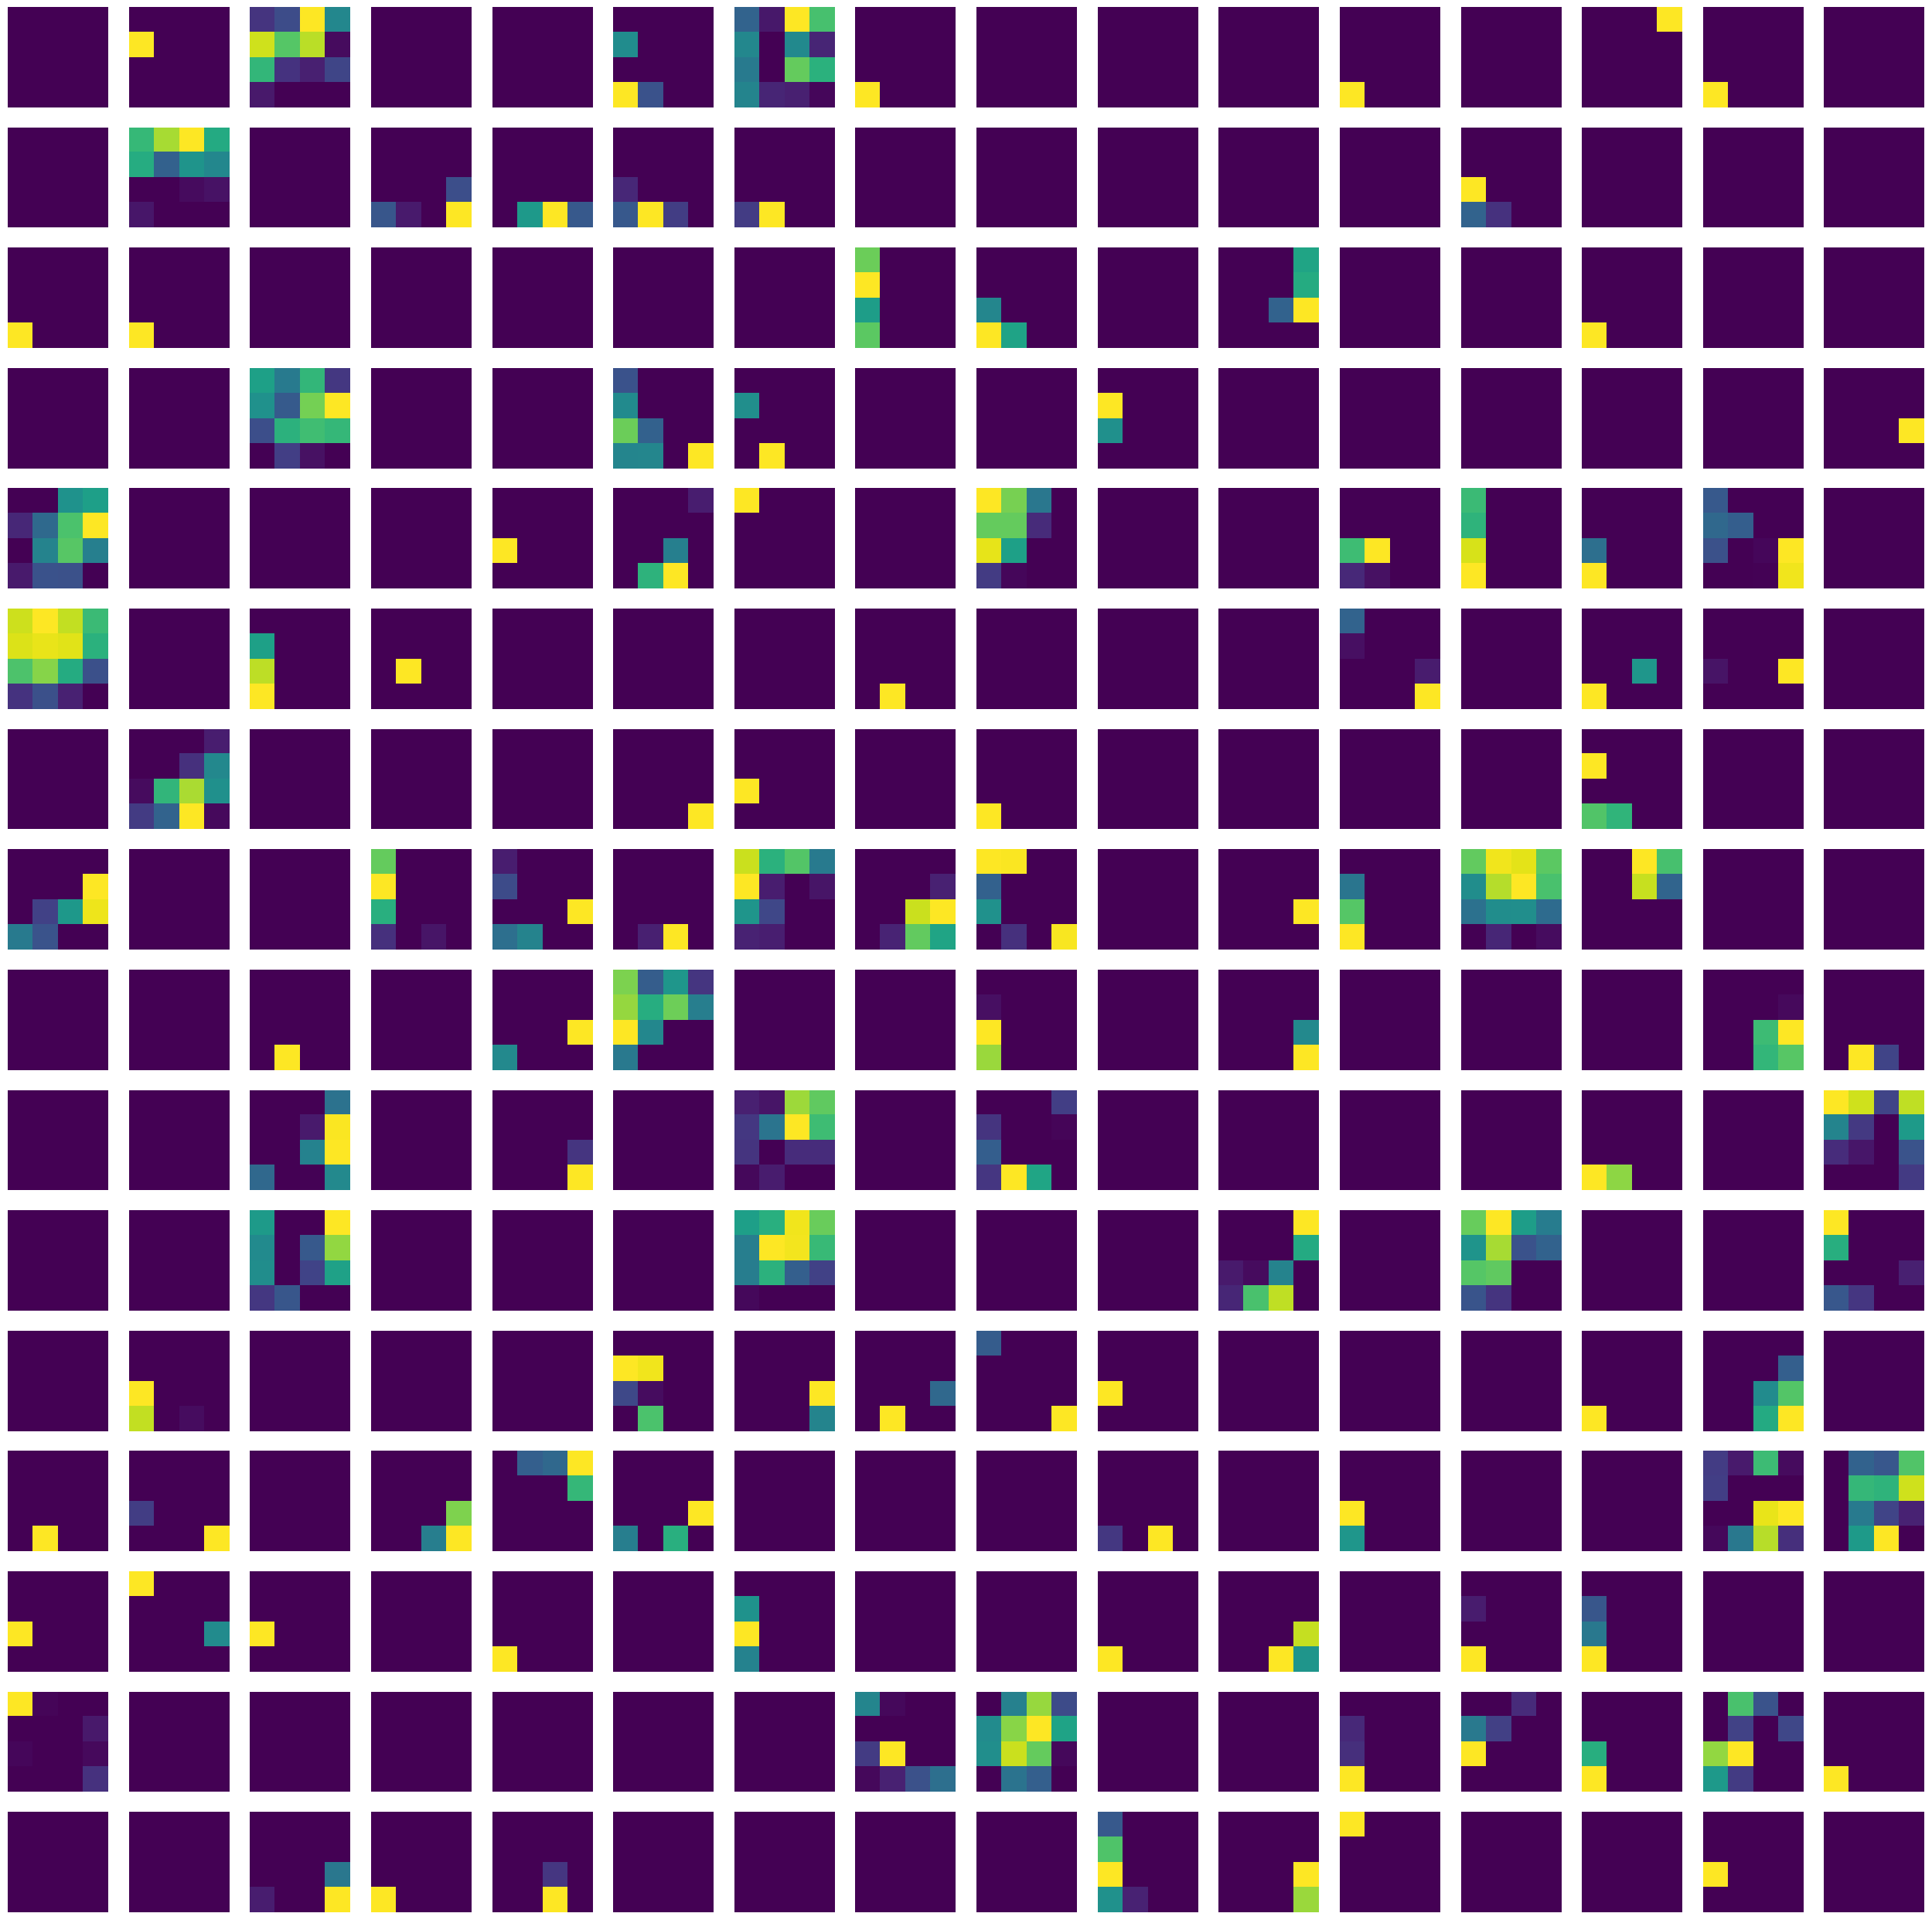

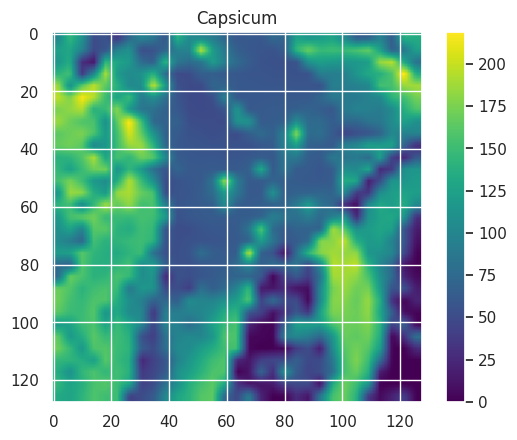

In [174]:
display_conv_activation(0, -6, figsize=(32, 32))
display_vege(0)

## Basic CNN with 
* Image Augmentation Preprocessing Layer
* Learning Rate Scheduling

In [ ]:
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

custom_optimizer = Adam(learning_rate=lr_schedule)
model_large.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model_large.fit(
    x = datagen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=50,
    batch_size=50,
    validation_data=(val_images, val_labels)
)

accuracy = model_large.evaluate(test_images, test_labels, verbose=0)[1]

print(f"Accuracy for small images (128x128): {accuracy:.2f}")

Epoch 1/50
91/91 [==============================] - 13s 123ms/step - loss: 0.1808 - accuracy: 0.9448 - val_loss: 0.1637 - val_accuracy: 0.9540
Epoch 2/50
91/91 [==============================] - 12s 127ms/step - loss: 0.1521 - accuracy: 0.9507 - val_loss: 0.2843 - val_accuracy: 0.9230
Epoch 3/50
91/91 [==============================] - 12s 126ms/step - loss: 0.1607 - accuracy: 0.9487 - val_loss: 0.1613 - val_accuracy: 0.9553
Epoch 4/50
91/91 [==============================] - 12s 130ms/step - loss: 0.1483 - accuracy: 0.9540 - val_loss: 0.1490 - val_accuracy: 0.9587
Epoch 5/50
91/91 [==============================] - 11s 122ms/step - loss: 0.1498 - accuracy: 0.9507 - val_loss: 0.1943 - val_accuracy: 0.9450
Epoch 6/50
91/91 [==============================] - 11s 123ms/step - loss: 0.1681 - accuracy: 0.9453 - val_loss: 0.1628 - val_accuracy: 0.9527
Epoch 7/50
91/91 [==============================] - 12s 130ms/step - loss: 0.1326 - accuracy: 0.9586 - val_loss: 0.1588 - val_accuracy: 0.9520

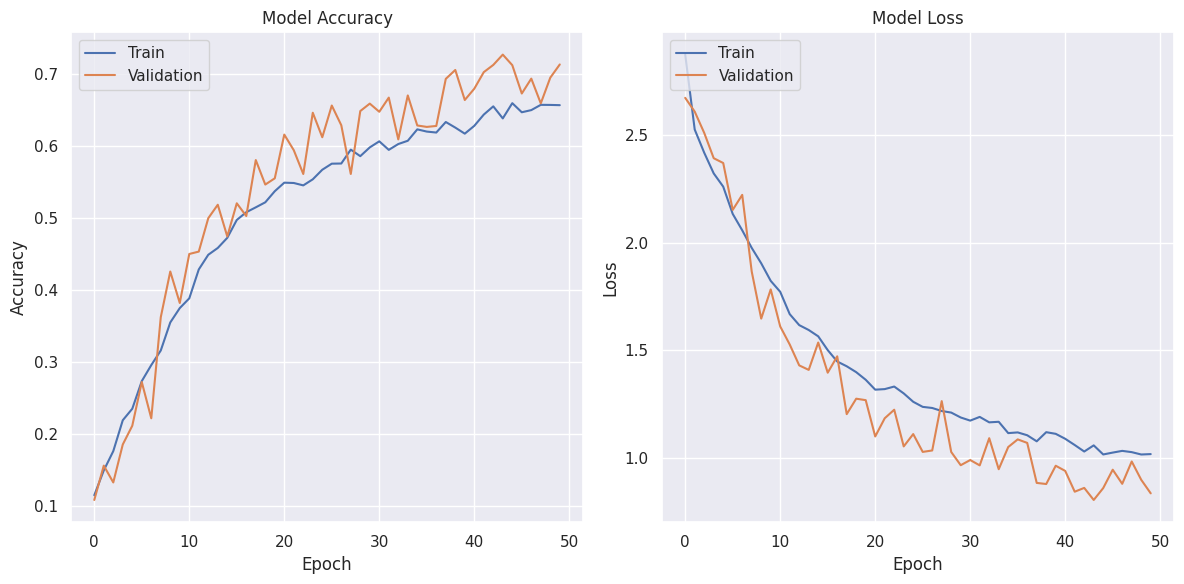

In [39]:
plot_history(history)

## Basic CNN with 
* Image Augmentation Preprocessing Layer
* Learning Rate Scheduling
* LeakyReLU Activation

In [41]:
model_small = Sequential([
    image_augmentation,
    resize_small,
    Conv2D(32, (3, 3), input_shape=(31, 31, 1)),
    LeakyReLU(alpha=0.1),
    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.1),
    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(400),
    LeakyReLU(alpha=0.1),
    Dense(400),
    LeakyReLU(alpha=0.1),
    Dense(15, activation='softmax')
])

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000000, decay_rate=0.96, staircase=True)

custom_optimizer = Adam(learning_rate=lr_schedule)
model_small.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model_small.fit(train_images, train_labels, epochs=50, batch_size=50, validation_data=(val_images, val_labels))

small_accuracy = model_small.evaluate(test_images, test_labels, verbose=0)[1]

print(f"Accuracy for small images (31x31): {small_accuracy:.2f}")

Epoch 1/50
181/181 [==============================] - 6s 30ms/step - loss: 2.7678 - accuracy: 0.1379 - val_loss: 2.7177 - val_accuracy: 0.1270
Epoch 2/50
181/181 [==============================] - 5s 29ms/step - loss: 2.3865 - accuracy: 0.1865 - val_loss: 2.4109 - val_accuracy: 0.2263
Epoch 3/50
181/181 [==============================] - 5s 28ms/step - loss: 2.2570 - accuracy: 0.2383 - val_loss: 2.1434 - val_accuracy: 0.2737
Epoch 4/50
181/181 [==============================] - 5s 28ms/step - loss: 2.1374 - accuracy: 0.2727 - val_loss: 2.0482 - val_accuracy: 0.2747
Epoch 5/50
181/181 [==============================] - 5s 30ms/step - loss: 2.0181 - accuracy: 0.3137 - val_loss: 1.8278 - val_accuracy: 0.3890
Epoch 6/50
181/181 [==============================] - 5s 29ms/step - loss: 1.9487 - accuracy: 0.3344 - val_loss: 1.8695 - val_accuracy: 0.3407
Epoch 7/50
181/181 [==============================] - 5s 29ms/step - loss: 1.8109 - accuracy: 0.3806 - val_loss: 1.7950 - val_accuracy: 0.3880

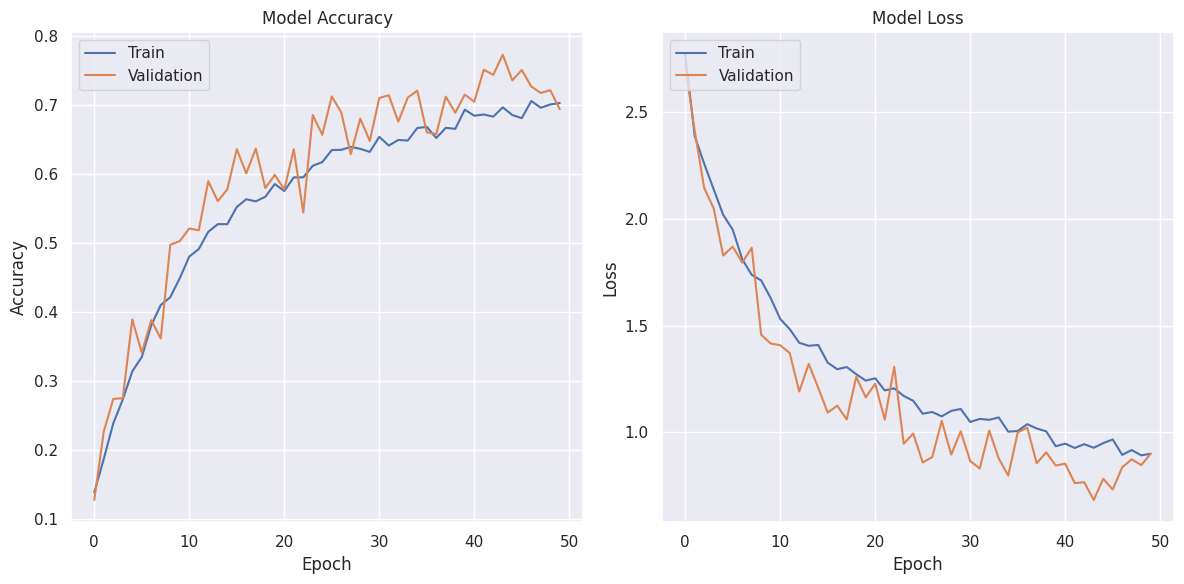

In [42]:
plot_history(history)

The peak validation accuracy has increased with LeakyReLU over ReLU so this seems like an improvement.

In [ ]:
model_small = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1), kernel_regularizer=l2(0.01)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(15, activation='softmax')
])

# Compile the model
model_small.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model for small images
history = model_small.fit(small_train_images, small_train_labels, epochs=10, batch_size=50, validation_data=(small_val_images, small_val_labels))

small_accuracy = model_small.evaluate(small_test_images, small_test_labels, verbose=0)[1]

print(f"Accuracy for small images (31x31): {small_accuracy:.2f}")

history.history

In [ ]:

    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),

In [ ]:
# Create the neural network model for small images
fast_model_small = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(15, activation='softmax')
])

In [414]:
model_small.summary()

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_84 (Sequential)  (None, 224, 224, 1)       0         
                                                                 
 resizing_21 (Resizing)      (None, 31, 31, 1)         0         
                                                                 
 conv2d_100 (Conv2D)         (None, 29, 29, 32)        320       
                                                                 
 conv2d_101 (Conv2D)         (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_102 (Conv2D)         (None, 11, 11, 64)        36928     
                                                     

## Inception

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import SparseCategoricalAccuracy

def inception_module(x, filters):
    conv1x1 = Conv2D(filters[0], kernel_size=1, padding='same')(x)
    conv1x1 = LeakyReLU(alpha=0.1)(conv1x1)
    conv3x3 = Conv2D(filters[1], kernel_size=3, padding='same', activation='relu')(x)
    conv3x3 = LeakyReLU(alpha=0.1)(conv3x3)
    conv5x5 = Conv2D(filters[2], kernel_size=5, padding='same', activation='relu')(x)
    conv5x5 = LeakyReLU(alpha=0.1)(conv5x5)
    maxpool = MaxPooling2D(pool_size=3, strides=1, padding='same')(x)
    return concatenate([conv1x1, conv3x3, conv5x5, maxpool], axis=-1)

input_tensor = Input(shape=(31, 31, 1))
x = Conv2D(64, kernel_size=7, strides=2, padding='same')(input_tensor)
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

x = inception_module(x, [64, 64, 64])
x = inception_module(x, [64, 64, 64])
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

x = AveragePooling2D(pool_size=2, strides=1)(x)
x = Dropout(0.4)(x)  # Dropout for regularization
x = Flatten()(x)
output_tensor = Dense(15, activation='softmax')(x)

initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
custom_optimizer = Adam(learning_rate=lr_schedule)

inceptionv3_model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
inceptionv3_model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# resnet_model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)


# resnet_model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# from tensorflow.keras.applications import ResNet50
# resnet_model = ResNet50()

small_train_images = resize_small(train_images)
small_val_images = resize_small(val_images)
small_test_images = resize_small(test_images)

history = inceptionv3_model.fit(
    x = datagen.flow(small_train_images, train_labels, batch_size=50),
    epochs=50,
    batch_size=50,
    validation_data=(small_val_images, val_labels)
)

accuracy = inceptionv3_model.evaluate(small_test_images, test_labels, verbose=0)[1]

print(f"Accuracy for small images (31x31): {accuracy:.2f}")

Epoch 1/50
181/181 [==============================] - 2s 7ms/step - loss: 18.6188 - accuracy: 0.1007 - val_loss: 6.4683 - val_accuracy: 0.1267
Epoch 2/50
181/181 [==============================] - 1s 7ms/step - loss: 7.5740 - accuracy: 0.1289 - val_loss: 4.6527 - val_accuracy: 0.1473
Epoch 3/50
181/181 [==============================] - 1s 7ms/step - loss: 5.4479 - accuracy: 0.1410 - val_loss: 4.2016 - val_accuracy: 0.1287
Epoch 4/50
181/181 [==============================] - 1s 7ms/step - loss: 4.5500 - accuracy: 0.1464 - val_loss: 4.1185 - val_accuracy: 0.1463
Epoch 5/50
181/181 [==============================] - 1s 7ms/step - loss: 4.0469 - accuracy: 0.1525 - val_loss: 3.8638 - val_accuracy: 0.1570
Epoch 6/50
181/181 [==============================] - 1s 7ms/step - loss: 3.7839 - accuracy: 0.1592 - val_loss: 3.9134 - val_accuracy: 0.1437
Epoch 7/50
 25/181 [===>..........................] - ETA: 1s - loss: 3.7121 - accuracy: 0.1632

KeyboardInterrupt: 

In [26]:
inceptionv3_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 31, 31, 1)]          0         []                            
                                                                                                  
 conv2d_90 (Conv2D)          (None, 16, 16, 64)           3200      ['input_10[0][0]']            
                                                                                                  
 max_pooling2d_45 (MaxPooli  (None, 8, 8, 64)             0         ['conv2d_90[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_91 (Conv2D)          (None, 8, 8, 64)             4160      ['max_pooling2d_45[0][0]